In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pltlab

import numpy as np
import scipy 
import pickle
import pandas as pd
import scipy.stats
from pathlib import Path
import os
from tqdm import tqdm
from ast import literal_eval

%matplotlib inline

# plt.rcParams['figure.dpi'] = 200
import seaborn as sns
sns.set(color_codes=True)

In [47]:
AGENT_LIST = ["h-opt", ]
AGENT_LIST += [ f"s-opt-{i}" for i in range(1,5) ]

## Hyper-params associated with best_params

In [4]:
SEED_LIST = range(0,2)

ENV_NAME = 'costly_large_grid-200' 

# base for all the logs 
BASE_PATH = "enter/path/here"

In [5]:
def get_df(seed=0):
    """
    loads the df and converts the lists while loading
    """
    converter_dict = {'pib_C_true_performance': eval, 
                      'piSolution_C_true_performance': eval,
                      'coeff': eval,
                     }
    
    df = pd.read_csv(filepath_or_buffer=f"{BASE_PATH}/{ENV_NAME}/s_{seed}/results.csv", 
                     converters=converter_dict)
    
    return df

### Load the DF and merge them

In [7]:
# Load the df
df_indv_list = []

for seed in SEED_LIST:
    seed_df = get_df(seed=seed)
    
    # within a saved df all run starts from 0 
    # add an identifier to them for now
    seed_df['run_id'] = seed_df['run_id'] + seed*100
    
    #append to the list for concatenation
    df_indv_list.append(seed_df)

results_df = pd.concat(df_indv_list)

results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840 entries, 0 to 1919
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     3840 non-null   int64  
 1   run_id                         3840 non-null   int64  
 2   num_constraints                3840 non-null   int64  
 3   gamma                          3840 non-null   float64
 4   cost_limit                     3840 non-null   float64
 5   nb_states                      3840 non-null   int64  
 6   nb_actions                     3840 non-null   int64  
 7   nb_trajectories                3840 non-null   int64  
 8   ratio                          3840 non-null   float64
 9   pib_R_true_performance         3840 non-null   float64
 10  pib_C_true_performance         3840 non-null   object 
 11  piSolution_R_true_performance  3840 non-null   float64
 12  piSolution_C_true_performance  3840 non-null   o

In [8]:
# num of diff runs 
NUM_RUNS = results_df.run_id.unique().shape[0]
NUM_RUNS

10

In [9]:
results_df.nb_trajectories.unique()

array([  10,   50,  500, 2000])

In [10]:
results_df.shape

(3840, 20)

In [11]:
# Dataset generation hyper-parameters
NB_TRAJ_LIST = results_df.nb_trajectories.unique()
RATIO_LIST  = results_df.ratio.unique()

In [12]:
EPS_LIST = results_df.epsilon.unique()
EPS_LIST = EPS_LIST[~np.isnan(EPS_LIST)]
EPS_LIST

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [13]:
DELTA_LIST = results_df.delta.unique()
DELTA_LIST = DELTA_LIST[~np.isnan(DELTA_LIST)]
DELTA_LIST

array([0.1])

In [14]:
results_df.delta_hcpi.unique()

array([nan, 0.1])

In [15]:
NB_COSTS = results_df.num_constraints.unique()
NB_COSTS

array([ 1,  4, 16, 64])

In [16]:
results_df.cost_limit.unique()

array([10.])

## Util functions

In [18]:
def scalarize_returns_and_safe_check(old_df):
    """
    a bit expensive, but loops over the df and calculates the scalarized returns and safety columns
    """
    # don't modify the original
    df = old_df.copy() 
    
    # add new empty columns 
    df['piSolution_linearized_return'] = 0.0
    df['pib_linearized_return'] = 0.0
    df['is_safe'] = False
    df['improved_return'] = 0.0
    
    for index, row in df.iterrows():
        
        # get the lambda coeffs
        coeff = row['coeff']
        # get the baseline stats
        pib_R = row['pib_R_true_performance']
        pib_C_list = row['pib_C_true_performance']
        # get the pi_solution stats
        sol_R = row['piSolution_R_true_performance']
        sol_C_list = row['piSolution_C_true_performance']
        
        # get the scalarized return 
        num_costs = len(pib_C_list)        
        assert num_costs == row['num_constraints']
        assert len(coeff) == num_costs + 1
        
        # for baseline
        pib_scalar = coeff[0] * pib_R
        for i in range(num_costs):
            pib_scalar -= (coeff[1+i] * pib_C_list[i])
        # row['pib_linearized_return'] = pib_scalar
        df.at[index, 'pib_linearized_return'] = pib_scalar
        
        # for solution
        sol_scalar = coeff[0] * sol_R
        for i in range(num_costs):
            sol_scalar -= (coeff[1+i] * sol_C_list[i])
        # row['piSolution_linearized_return'] = sol_scalar
        df.at[index, 'piSolution_linearized_return'] = sol_scalar
        
        # set the safety flag
        safe = sol_R >= pib_R
        for i in range(num_costs):
            safe = safe and (sol_C_list[i] <= pib_C_list[i])
        # row['is_safe'] = safe
        df.at[index, 'is_safe'] = safe
    
        # calculate the improved return
        df.at[index,'improved_return' ] = sol_scalar - pib_scalar
        
    return df

In [19]:
def get_agents_on_delta(df, agent_type='s-opt', delta=0.1):
    """
    this means for s-opt delta value should match to the input
    and for h-opt delta_hcpi should match to input
    """
    assert delta in DELTA_LIST
    
    if agent_type=='s-opt':
        return df[df.agent_name.str.contains('S_OPT') & (df['delta']==delta)]
    else:
        return df[df.agent_name.str.contains('H_OPT') & (df['delta_hcpi']==delta)]


In [48]:
def select_agent_df(df, agent_name):
    """
    filters the df based on the agent type
    """
    if agent_name == 's-opt-0':
        agent_df = df[df.agent_name.str.contains('S_OPT') & (df['epsilon']==EPS_LIST[0])]
    elif agent_name == 's-opt-1':
        agent_df = df[df.agent_name.str.contains('S_OPT') & (df['epsilon']==EPS_LIST[1])]
    elif agent_name == 's-opt-2':
        agent_df = df[df.agent_name.str.contains('S_OPT') & (df['epsilon']==EPS_LIST[2])]
    elif agent_name == 's-opt-3':
        agent_df = df[df.agent_name.str.contains('S_OPT') & (df['epsilon']==EPS_LIST[3])]
    elif agent_name == 's-opt-4':
        agent_df = df[df.agent_name.str.contains('S_OPT') & (df['epsilon']==EPS_LIST[4])]
    elif agent_name == 'h-opt':
        agent_df = df[df.agent_name.str.contains('H_OPT')]
    else: 
        raise Exception('unkown agent')
        
    return agent_df

## Matplot lib utils

In [55]:
MARKER_DICT = { "s-opt-2" : '*', 
               "s-opt-3" : 'd', 
               "s-opt-4" : 'p', 
               "h-opt" : 's', 
               #"reg-PI" : '>',
               #"rs-PI" : '<',
               "s-opt-0" : '>',
               "s-opt-1" : '<',
#                "adv-rs-PI": 'v', 
              }

# marler info can be found https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers 
# use 'o', 'd', 'D'

MARKER_SIZE = 5

MARKER_OPACITY = 0.75

In [56]:
AGENT_LABEL_DICT = { "s-opt-0" : f"S-OPT-$\epsilon=${EPS_LIST[0]}", 
                    "s-opt-1" : f"S-OPT-$\epsilon=${EPS_LIST[1]}", 
                    "s-opt-2" : f"S-OPT-$\epsilon=${EPS_LIST[2]}", 
                    "h-opt" : 'H-OPT', 
                    "s-opt-3" : f"S-OPT-$\epsilon=${EPS_LIST[3]}", 
                    "s-opt-4" : f"S-OPT-$\epsilon=${EPS_LIST[4]}", 
                    #"reg-PI" : 'Unconstrained', 
                    #"rs-PI" : 'Linearized', 
                    #"adv-rs-PI": 'Adv-Linearized', #d
                   }

AGENT_COLOR_DICT = { "s-opt-2" : "red", 
                    "s-opt-3" : "brown", 
                    "s-opt-4" : "orange", 
                    "s-opt-0" : "deeppink", 
                    "s-opt-1" : "orchid", 
                    "h-opt" : 'blue', 
                    #"reg-PI" : 'black', 
                    #"rs-PI" : 'green', 
                    #"adv-rs-PI": 'violet',
                   }

## Plot single run

In [38]:
scalarized_results_df = scalarize_returns_and_safe_check(results_df)

In [57]:
def plot_results_for_lambda_rho(ax_imp, ax_failure, df, num_cost, ratio, delta, plot=True, print_=False):
    """
    two plots for each combination
    """
    results_dict = {}
    
    # get filter/index the dataframe 
    condition =  df.ratio.eq(ratio) & df.num_constraints.eq(num_cost)
    filtered_df = df[condition]
    
    # can't be empty
    assert filtered_df.shape[0] > 0
   
    # Get the unconstrainted agent too
    # it is independent of reward weighing (coeffs) but depends on ratio here 
    # baseline_df = filtered_df[(filtered_df['agent_name'] == 'Reshaped_PI') | (filtered_df['agent_name'] == 'Reshaping_Adv_PI')]
    # unconst_df = df[(df['agent_name'] == 'Unconstrained_PI')  & (df['ratio']==ratio)]
    sopt_df = get_agents_on_delta(filtered_df, 's-opt', delta)
    hopt_df = get_agents_on_delta(filtered_df, 'h-opt', delta)
    # add all them up
#     trajs_and_agents_df = pd.concat([baseline_df, unconst_df, sopt_df, hopt_df]).copy()
    trajs_and_agents_df = pd.concat([sopt_df, hopt_df]).copy()
        
    # now plot for each agent 
    for agent_name in AGENT_LIST:
    
        # init empty dict
        results_dict[agent_name] = {}

        for traj_idx, nb_traj in enumerate(NB_TRAJ_LIST):
            # plots across trajs here 
            # filter the result based on nb_traj
            agent_traj_df = trajs_and_agents_df[(trajs_and_agents_df['nb_trajectories']==nb_traj)]

            # filter the agent 
            agent_df = select_agent_df(agent_traj_df, agent_name)

            # only one agent for each run
            assert agent_df.run_id.unique().shape[0] == NUM_RUNS
    
            # get the improvement 
            imp_mean = np.mean(agent_df.improved_return)
            imp_std = np.std(agent_df.improved_return)
            imp_sem = scipy.stats.sem(agent_df.improved_return)
    
            # get the failure rate 
            failure_rate_mean = np.mean(1. - agent_df.is_safe)
            failure_rate_std = np.std(1. - agent_df.is_safe)
            failure_rate_sem = scipy.stats.sem(1. - agent_df.is_safe)
            
            # save the results 
            results_dict[agent_name][nb_traj] = {'imp_mean' : imp_mean, 
                                                 'imp_std' : imp_std,
                                                 'imp_sem' : imp_sem,
                                                 'failure_rate_mean' : failure_rate_mean,
                                                 'failure_rate_std' :failure_rate_std,
                                                 'failure_rate_sem' :failure_rate_sem,
                                                 'imp_list' : agent_df.improved_return.to_list(), 
                                                 'fail_list' : (1. - agent_df.is_safe).to_list(), 
                                                }
            
            if print_:
                print(f"{agent_name} with {nb_traj}\t L:{imp_mean:0.2f} +/- {imp_std:0.2f}\t \tFailure rate:{failure_rate_mean:0.2f} +/- {failure_rate_std:0.2f}")
            
        # plot here
        if plot:
            
            # plot the line for that agent 
            # create x-makers
            x_range = np.arange(len(NB_TRAJ_LIST)) + 1.0
            
            ax_imp.errorbar(x=x_range, 
                            y=[results_dict[agent_name][nb_traj]['imp_mean'] for nb_traj in NB_TRAJ_LIST], 
                            yerr=[results_dict[agent_name][nb_traj]['imp_sem'] for nb_traj in NB_TRAJ_LIST],  
                            marker=MARKER_DICT[agent_name], 
                            label= AGENT_LABEL_DICT[agent_name],
                            alpha = MARKER_OPACITY,
                            c = AGENT_COLOR_DICT[agent_name]
                        )
    
            ax_failure.errorbar(x=x_range, 
                                y= [results_dict[agent_name][nb_traj]['failure_rate_mean'] for nb_traj in NB_TRAJ_LIST], 
                                yerr= [results_dict[agent_name][nb_traj]['failure_rate_sem'] for nb_traj in NB_TRAJ_LIST],
                                marker=MARKER_DICT[agent_name], 
                                label= AGENT_LABEL_DICT[agent_name],
                                alpha = MARKER_OPACITY,
                                c = AGENT_COLOR_DICT[agent_name]
                               )

        
    if plot:
        # Final plotting details 

        # plot the baseline stats
        ax_imp.axhline(y= 0.0, linestyle=":", c="black")
        ax_failure.set_ylim([-0.2, 1.2])
        ax_failure.axhline(y= CURRENT_DELTA, label = f"$\delta$={CURRENT_DELTA}", linestyle="--", c='black')        
        
        # put labels and stuff
        # only label on the lower axis
        ax_failure.set_xticks(np.arange(len(NB_TRAJ_LIST))+1.0)
        ax_failure.set_xticklabels(NB_TRAJ_LIST, fontsize=12)
        ax_failure.set_xlabel('$|\mathcal{D}|$ - num of trajectories', fontsize=14)
        # y-labels
        ax_failure.set_ylabel('Failure Rate', fontsize=14)
        ax_imp.set_ylabel(f"Improvement over $\pi_b$", fontsize=14)
        # remove -0.2, 1.2 ticks
        ax_failure.set_yticks(ax_failure.get_yticks()[1:-1])
        
        
        

    return results_dict

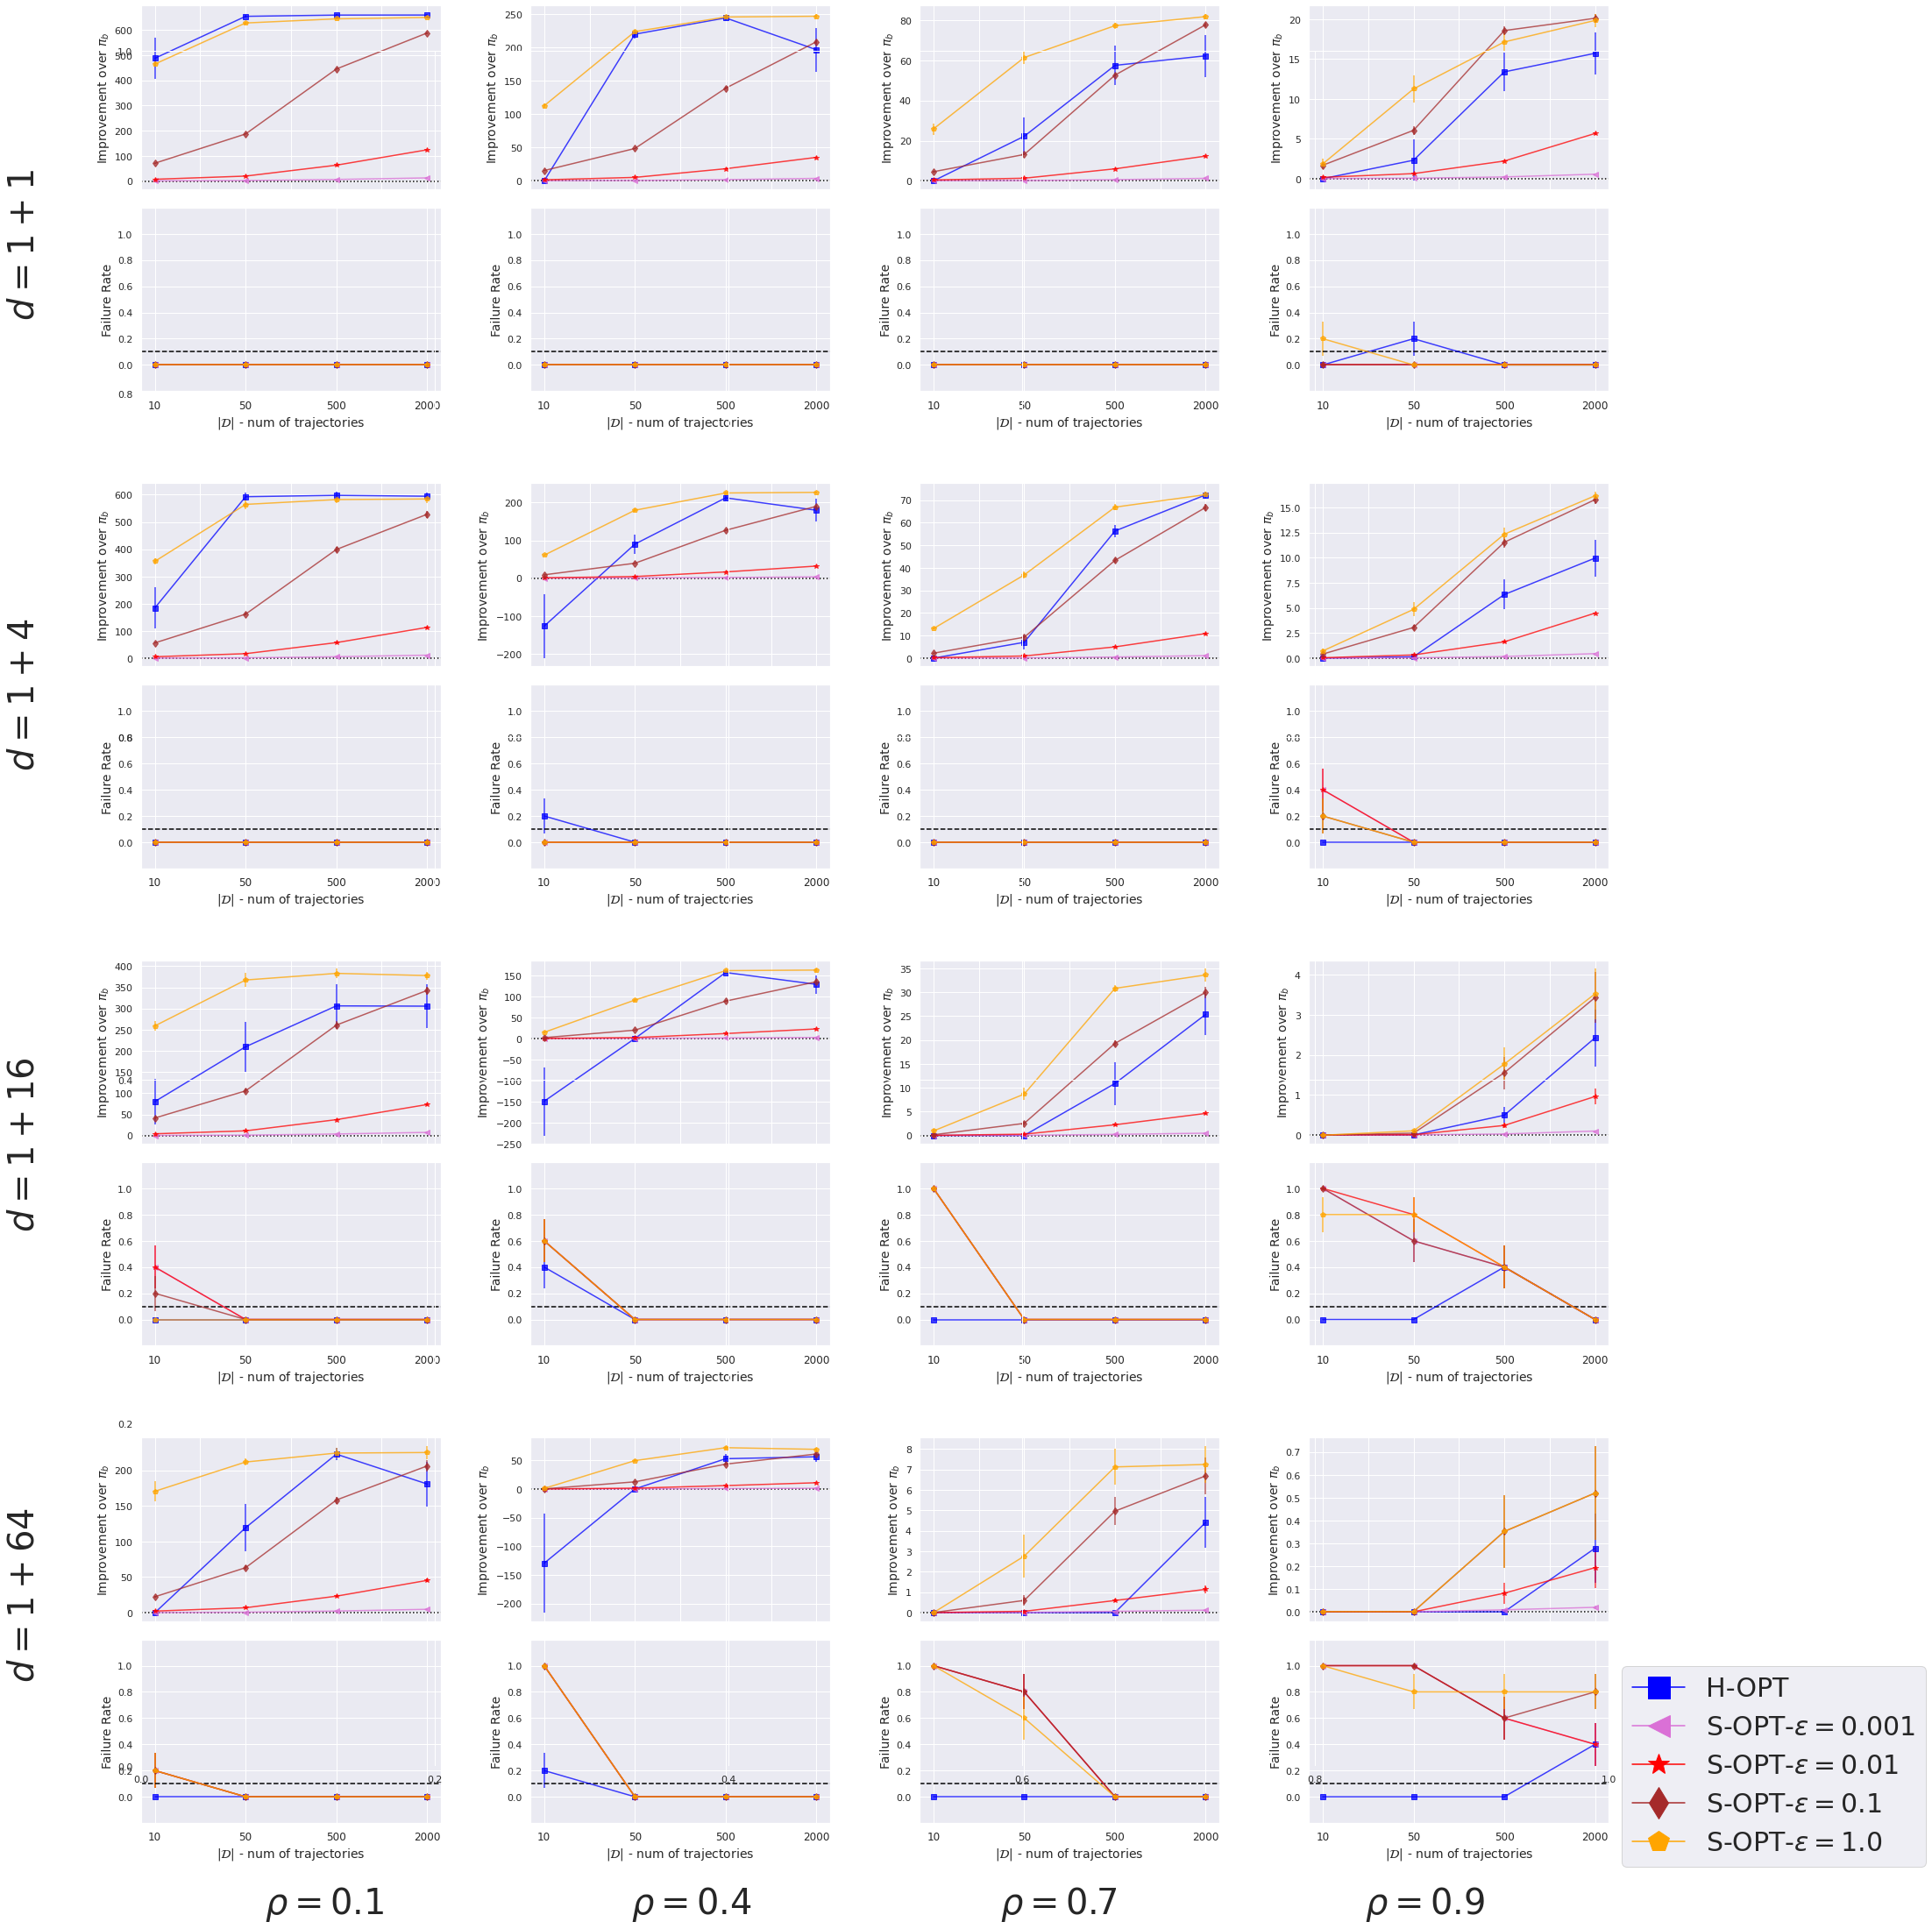

In [58]:
CURRENT_DELTA = 0.1

# same as the above 
FIG_LEN = 30 # 36

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

n = len(NB_COSTS) # number of double-rows, |costs|
m = len(RATIO_LIST) # number of columns

t = 0.9 # 1-t == top space 
b = 0.1 # bottom space      (both in figure coordinates)

msp = 0.1 # minor spacing
sp = 0.5  # major spacing

offs=(1+msp)*(t-b)/(2*n + n*msp + (n-1)*sp) # grid offset
hspace = sp+msp+1 #height space per grid
wspace = 0.3

gso = GridSpec(n,m, bottom=b+offs, top=t, hspace=hspace, wspace=wspace)
gse = GridSpec(n,m, bottom=b, top=t-offs, hspace=hspace, wspace=wspace)

fig = plt.figure(figsize=(FIG_LEN, FIG_LEN*1.2)) #w,h , more lenghty #1.2

axes = []
imp_axes = []
fail_axes = []


# scalarize this once 
scalarized_results_df = scalarize_returns_and_safe_check(results_df)

for i, num_cost in enumerate(NB_COSTS):
    for j, ratio in enumerate(RATIO_LIST):
        # set the axis first 
        ax_imp = fig.add_subplot(gso[i, j])
#         ax_imp.text(0.5, 0.5, f"Imp-ax({i},{j})", va="center", ha="center")
        ax_imp.tick_params(labelbottom=False)
        
        ax_safe = fig.add_subplot(gse[i, j])
#         ax_safe.text(0.5, 0.5, f"Safe-ax({i},{j})", va="center", ha="center")
        
        # plot the axes 
        plot_results_for_lambda_rho(ax_imp, ax_safe, scalarized_results_df, 
                                    num_cost=num_cost,
                                    ratio=ratio, 
                                    delta=CURRENT_DELTA,
                                    print_=False, 
                                    plot=True)

        
# add the grid labels
nr_rows = n
nr_cols = m

fig.add_subplot(111, frameon=False)
# define the rows and columns
xranges = [f"$\\rho={i}$" for i in RATIO_LIST]
yranges = [f"$d=1+{i}$" for i in NB_COSTS]

for pos, text in enumerate(xranges):
    plt.text(pos * (1/nr_cols) + 0.5*(1/nr_cols), -0.08, text, fontsize=40, ha='center', va='center')

# this place bottom to top, whereas rows are generated top to bottom    
for pos, text in enumerate(yranges[::-1]):
    plt.text(-0.08, (pos*1.05)* (1/nr_rows) + 0.4*(1/nr_rows), text, fontsize=40, ha='center', va='center', rotation='vertical')

    
# add the legend here manually
import matplotlib.lines as mlines

legend_elements = []
for agent in AGENT_LIST:
    legend_elements.append(mlines.Line2D([0], [0], marker=MARKER_DICT[agent], 
                                         color=AGENT_COLOR_DICT[agent], 
                                         label=AGENT_LABEL_DICT[agent],
                                         markersize=25) )

    

# Create the figure
# cordinates are now wrt to ax2
plt.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.0), loc='center left', prop={'size':30})

    
plt.show()


